In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import keras
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [4]:
(X_train, _), (_, _) = mnist.load_data()

In [5]:
X_train[:5]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train = (X_train-127.5)/127.5

print(X_train.min())
print(X_train.max())

-1.0
1.0


In [8]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
HALF_BATCH = 128

NO_OF_BATCHES = int(X_train.shape[0]/BATCH_SIZE)

NOISE_DIM = 100

adam = Adam(lr = 2e-4, beta_1 = 0.5)

In [9]:
#Generator Modeling --> Up Sampling

generator = Sequential()
generator.add(Dense(units= 7*7*128, input_shape = (NOISE_DIM, )))
generator.add(Reshape((7, 7, 128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#(7, 7, 128) -> (14, 14, 64)
generator.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#(14, 14, 64) --> (28, 28, 1)
generator.add(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='tanh'))


generator.compile(loss = keras.losses.binary_crossentropy, optimizer=adam)

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        2

In [10]:
#Discriminator Modeling --> Down Sampling

# (28, 28, 1) --> (14, 14, 64)
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape = (28, 28, 1)))
discriminator.add(LeakyReLU(0.2))

#(14, 14, 64) --> (7, 7, 128)
discriminator.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))

#(7, 7, 128) --> 6272
discriminator.add(Flatten())
discriminator.add(Dense(100))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss = keras.losses.binary_crossentropy, optimizer=adam)

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               627300    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 100)              

In [11]:
## Combied  Model 

discriminator.trainable = False
gan_input = Input(shape = (NOISE_DIM, ))

generated_img = generator(gan_input)

gan_output  = discriminator(generated_img)

model = Model(gan_input, gan_output)

model.compile(loss = "binary_crossentropy", optimizer=adam)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         708609    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 701897    
Total params: 1,410,506
Trainable params: 708,225
Non-trainable params: 702,281
_________________________________________________________________


In [13]:
#16.01
X_train = X_train.reshape(-1, 28, 28, 1)

In [14]:
X_train.shape

(60000, 28, 28, 1)

In [15]:
def display_images(samples = 25):

  noise = np.random.normal(0, 1, size=(samples, NOISE_DIM))

  generated_img = generator.predict(noise)

  plt.figure(figsize=(10, 10))

  for i in range(samples):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_img[i].reshape(28, 28), cmap="gray")
    plt.axis('off')

  plt.show()

Epoch : 1	,  Discriminator Loss : 0.25897651991146986	, Generator Loss : 1.1500072128983447
Epoch : 2	,  Discriminator Loss : 0.5677873889923605	, Generator Loss : 1.9773283661343157
Epoch : 3	,  Discriminator Loss : 0.5564669755279509	, Generator Loss : 1.508944047614932
Epoch : 4	,  Discriminator Loss : 0.5703185591687504	, Generator Loss : 1.4899448323994875
Epoch : 5	,  Discriminator Loss : 0.621234845274534	, Generator Loss : 1.3262150567024946
Epoch : 6	,  Discriminator Loss : 0.6406578118475075	, Generator Loss : 1.202875533606857
Epoch : 7	,  Discriminator Loss : 0.642724542472607	, Generator Loss : 1.1239283843897283
Epoch : 8	,  Discriminator Loss : 0.6468475127958844	, Generator Loss : 1.076513821259141
Epoch : 9	,  Discriminator Loss : 0.6445728270416586	, Generator Loss : 1.0509009454399347
Epoch : 10	,  Discriminator Loss : 0.6408960496385893	, Generator Loss : 1.0446941344998777


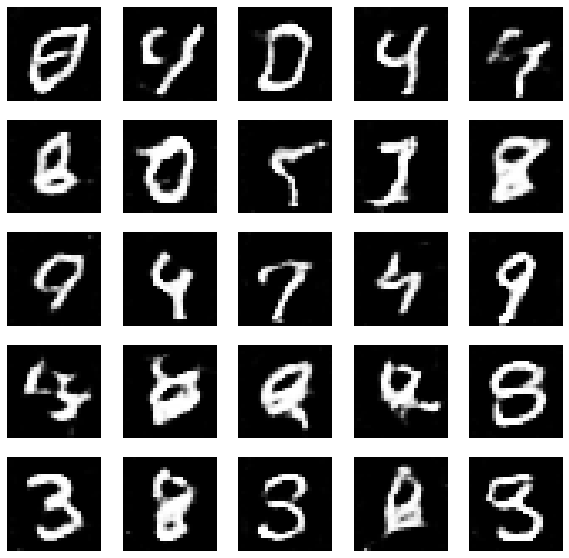

Epoch : 11	,  Discriminator Loss : 0.6384418318923722	, Generator Loss : 1.0431628935039043
Epoch : 12	,  Discriminator Loss : 0.6346017780721697	, Generator Loss : 1.0510233957320452
Epoch : 13	,  Discriminator Loss : 0.6293017765523022	, Generator Loss : 1.0606305003166199
Epoch : 14	,  Discriminator Loss : 0.627728250164252	, Generator Loss : 1.0750208436511457
Epoch : 15	,  Discriminator Loss : 0.6228110767327822	, Generator Loss : 1.0882596396841109
Epoch : 16	,  Discriminator Loss : 0.6196117878087566	, Generator Loss : 1.1075379643589258
Epoch : 17	,  Discriminator Loss : 0.6176279395436629	, Generator Loss : 1.1229150369763374
Epoch : 18	,  Discriminator Loss : 0.6122722696417418	, Generator Loss : 1.1390689704567194
Epoch : 19	,  Discriminator Loss : 0.6085224146516914	, Generator Loss : 1.1538683432154357
Epoch : 20	,  Discriminator Loss : 0.6066566740727832	, Generator Loss : 1.1693910746835172


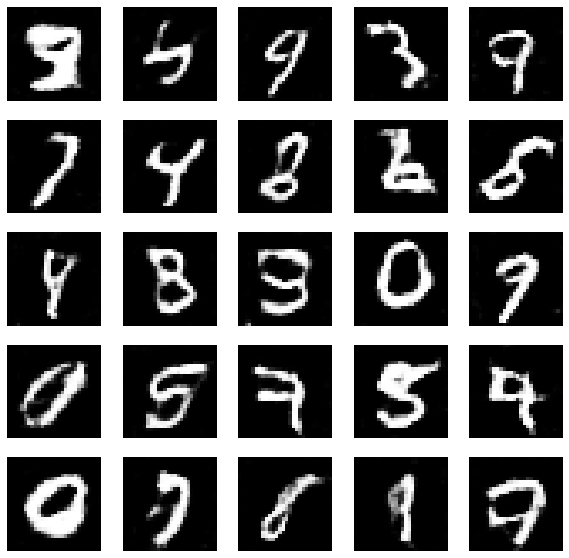

Epoch : 21	,  Discriminator Loss : 0.602334524003359	, Generator Loss : 1.1875906502828002
Epoch : 22	,  Discriminator Loss : 0.5961645199702337	, Generator Loss : 1.2087600654922426
Epoch : 23	,  Discriminator Loss : 0.5917488277340547	, Generator Loss : 1.2269037840887904
Epoch : 24	,  Discriminator Loss : 0.588474002849852	, Generator Loss : 1.2449386841617525
Epoch : 25	,  Discriminator Loss : 0.5847534902202778	, Generator Loss : 1.2666693241335452
Epoch : 26	,  Discriminator Loss : 0.5824602086447243	, Generator Loss : 1.2823588363826275
Epoch : 27	,  Discriminator Loss : 0.5752488893703518	, Generator Loss : 1.3039413881488144
Epoch : 28	,  Discriminator Loss : 0.5740281854811896	, Generator Loss : 1.3227286688052118
Epoch : 29	,  Discriminator Loss : 0.5692196453993137	, Generator Loss : 1.336845189332962
Epoch : 30	,  Discriminator Loss : 0.5646550363709784	, Generator Loss : 1.363026987761259


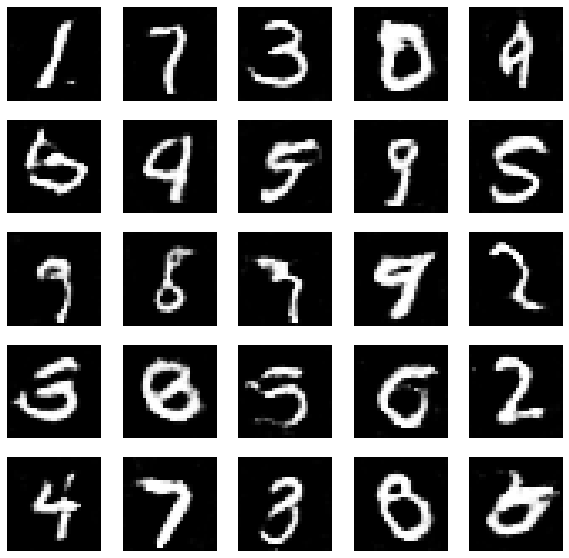

Epoch : 31	,  Discriminator Loss : 0.5610936939334258	, Generator Loss : 1.38051669113338
Epoch : 32	,  Discriminator Loss : 0.5583245352420032	, Generator Loss : 1.4010491534136236
Epoch : 33	,  Discriminator Loss : 0.5560213030021415	, Generator Loss : 1.4117896584793925
Epoch : 34	,  Discriminator Loss : 0.551736651895902	, Generator Loss : 1.4321725126355886
Epoch : 35	,  Discriminator Loss : 0.5484510293373694	, Generator Loss : 1.4534690156579018
Epoch : 36	,  Discriminator Loss : 0.5452823608349531	, Generator Loss : 1.472216120455414
Epoch : 37	,  Discriminator Loss : 0.5407460127503444	, Generator Loss : 1.4927041670307517
Epoch : 38	,  Discriminator Loss : 0.5395826534328297	, Generator Loss : 1.5051014479249716
Epoch : 39	,  Discriminator Loss : 0.5343595401216776	, Generator Loss : 1.5323396841995418
Epoch : 40	,  Discriminator Loss : 0.5327762364067583	, Generator Loss : 1.5455940044485033


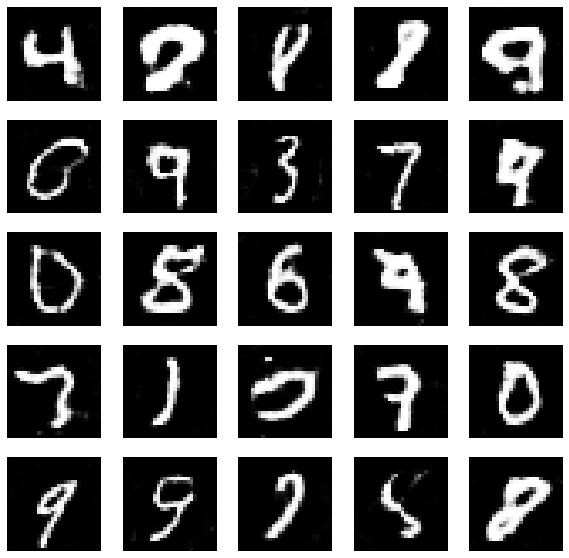

Epoch : 41	,  Discriminator Loss : 0.5268233622241224	, Generator Loss : 1.5714045697823167
Epoch : 42	,  Discriminator Loss : 0.5245334112491363	, Generator Loss : 1.5872529889456928
Epoch : 43	,  Discriminator Loss : 0.5242081062915998	, Generator Loss : 1.6051681796088815
Epoch : 44	,  Discriminator Loss : 0.5208847914368678	, Generator Loss : 1.61671904893592
Epoch : 45	,  Discriminator Loss : 0.5181905071959536	, Generator Loss : 1.6402175198309124
Epoch : 46	,  Discriminator Loss : 0.513563218088741	, Generator Loss : 1.6559885484166443
Epoch : 47	,  Discriminator Loss : 0.5162647416831082	, Generator Loss : 1.662609157152474
Epoch : 48	,  Discriminator Loss : 0.5104460544947885	, Generator Loss : 1.6869842074811459
Epoch : 49	,  Discriminator Loss : 0.5090000171564583	, Generator Loss : 1.6960045057348907
Epoch : 50	,  Discriminator Loss : 0.5098029869871262	, Generator Loss : 1.7018294632434845


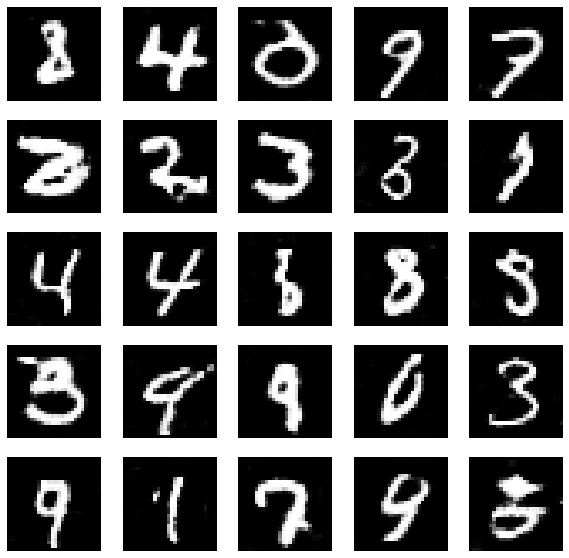

In [16]:
## Training Loop

d_losses = []
g_losses = []
for epoch in range(TOTAL_EPOCHS):

  epoch_d_loss = 0.0
  epoch_g_loss = 0.0

  for step in range(NO_OF_BATCHES):


    #++++++++++++++++++#
    #Step1. :- Train Discriminator
    discriminator.trainable = True

    #get the real data
    idx = np.random.randint(0, 60000, HALF_BATCH)
    real_imgs = X_train[idx]

    #get the fake data
    noise = np.random.normal(0, 1, size=(HALF_BATCH, NOISE_DIM))
    fake_imgs = generator.predict(noise)

    #Labels
    real_y = np.ones((HALF_BATCH, 1))*0.9
    fake_y = np.zeros((HALF_BATCH, 1))

    #now train D
    d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)

    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake

    epoch_d_loss += d_loss


    #++++++++++++++++++++++#
    #Step2. :- Train Generator
    discriminator.trainable = False

    noise = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE, 1))

    g_loss = model.train_on_batch(noise, ground_truth_y)

    epoch_g_loss += g_loss

    #++++++++++++++++++++++#

  print("Epoch : {}\t,  Discriminator Loss : {}\t, Generator Loss : {}".format((epoch+1), epoch_d_loss/NO_OF_BATCHES, epoch_g_loss/BATCH_SIZE))

  d_losses.append(epoch_d_loss/NO_OF_BATCHES)
  g_losses.append(epoch_g_loss/NO_OF_BATCHES)


  if (epoch+1)%10==0:
    generator.save('generator.h5')
    display_images()